In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

import torch

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"PyTorch CUDA compatibility: {torch.backends.cudnn.is_available()}")
else:
    print("CUDA is NOT available.")

# --- Define File Paths (Adjust if necessary) ---
BASE_DIR = '/content/drive/MyDrive/idrid/'
IMAGE_DIR_TRAIN = "/content/drive/MyDrive/idrid/1. Original Images/a. Training Set"
IMAGE_DIR_TEST = "/content/drive/MyDrive/idrid/1. Original Images/b. Testing Set"
CSV_PATH_TRAIN = "/content/drive/MyDrive/idrid/2. Groundtruths/train.csv"
CSV_PATH_TEST = "/content/drive/MyDrive/idrid/2. Groundtruths/test.csv"
def check_image_csv_consistency(csv_file_path, image_directory_path):
    """
    Checks for consistency between image names in a CSV file and image files on disk.

    Args:
        csv_file_path (str): Path to the CSV file containing image names.
        image_directory_path (str): Path to the directory containing image files.

    Returns:
        pd.DataFrame: A filtered DataFrame containing only entries for which
                      corresponding image files exist.
    """
    print(f"\n--- Checking consistency for: {csv_file_path} and {image_directory_path} ---")
    try:
        df = pd.read_csv(csv_file_path)

        # Identify the 'Image name' column, handling potential trailing spaces
        image_name_col = None
        if 'Image name' in df.columns:
            image_name_col = 'Image name'
        elif 'Image name ' in df.columns: # Check for trailing space
            image_name_col = 'Image name '

        if image_name_col is None:
            print(f"Error: 'Image name' column not found in {csv_file_path}. Available columns: {df.columns.tolist()}")
            return pd.DataFrame() # Return empty DataFrame if critical column is missing

        # Get list of image names from CSV (e.g., 'IDRiD_001')
        csv_image_names = set(df[image_name_col].apply(lambda x: x.strip()))
        print(f"Total image names in CSV: {len(csv_image_names)}")

        # Get list of actual image files on disk (e.g., 'IDRiD_001.jpg')
        actual_image_files = set()
        if os.path.exists(image_directory_path):
            for filename in os.listdir(image_directory_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')): # Consider common image extensions
                    actual_image_files.add(os.path.splitext(filename)[0].strip()) # Remove extension and strip spaces
            print(f"Total image files found in directory: {len(actual_image_files)}")
        else:
            print(f"Error: Image directory not found at {image_directory_path}")
            return pd.DataFrame()

        # Find discrepancies
        images_in_csv_missing_from_disk = csv_image_names - actual_image_files
        images_on_disk_not_in_csv = actual_image_files - csv_image_names

        print(f"\nImages in CSV but NOT found in directory ({len(images_in_csv_missing_from_disk)}):")
        if images_in_csv_missing_from_disk:
            for img_name in list(images_in_csv_missing_from_disk)[:10]: # Print first 10 if many
                print(f"  - {img_name}.jpg")
            if len(images_in_csv_missing_from_disk) > 10:
                print(f"  ...and {len(images_in_csv_missing_from_disk) - 10} more.")
        else:
            print("  None")

        print(f"\nImages in directory but NOT found in CSV ({len(images_on_disk_not_in_csv)}):")
        if images_on_disk_not_in_csv:
            for img_name in list(images_on_disk_not_in_csv)[:10]: # Print first 10 if many
                print(f"  - {img_name}.jpg")
            if len(images_on_disk_not_in_csv) > 10:
                print(f"  ...and {len(images_on_disk_not_in_csv) - 10} more.")
        else:
            print("  None")

        # Filter the DataFrame to keep only entries with existing image files
        # Create a boolean mask where image name from CSV exists in actual files
        df_filtered = df[df[image_name_col].apply(lambda x: x.strip() in actual_image_files)].copy()
        df_filtered.columns = [col.strip() for col in df_filtered.columns] # Clean all column names

        print(f"\nOriginal DataFrame size: {len(df)}")
        print(f"Filtered DataFrame size (images with existing files): {len(df_filtered)}")

        return df_filtered

    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_file_path}. Please check the path.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return pd.DataFrame()

# --- Run the consistency checks ---
if __name__ == "__main__":
    # Check training data
    filtered_train_df = check_image_csv_consistency(CSV_PATH_TRAIN, IMAGE_DIR_TRAIN)
    if not filtered_train_df.empty:
        print("\n--- Filtered Training Data Head ---")
        print(filtered_train_df.head())

    # Check test data (assuming test.csv and test image directory exist)
    filtered_test_df = check_image_csv_consistency(CSV_PATH_TEST, IMAGE_DIR_TEST)
    if not filtered_test_df.empty:
        print("\n--- Filtered Test Data Head ---")
        print(filtered_test_df.head())

    print("\nConsistency check complete. You should now use the filtered DataFrames for your Dataset creation.")


--- Checking consistency for: /content/drive/MyDrive/idrid/2. Groundtruths/train.csv and /content/drive/MyDrive/idrid/1. Original Images/a. Training Set ---
Total image names in CSV: 413
Total image files found in directory: 413

Images in CSV but NOT found in directory (0):
  None

Images in directory but NOT found in CSV (0):
  None

Original DataFrame size: 413
Filtered DataFrame size (images with existing files): 413

--- Filtered Training Data Head ---
  Image name  Retinopathy grade  Risk of macular edema  Unnamed: 3  \
0  IDRiD_001                  3                      2         NaN   
1  IDRiD_002                  3                      2         NaN   
2  IDRiD_003                  2                      2         NaN   
3  IDRiD_004                  3                      2         NaN   
4  IDRiD_005                  4                      0         NaN   

   Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0         NaN         NaN         NaN  

#Visualize Classifcation

--- Content of '/content/drive/MyDrive/idrid/2. Groundtruths/train.csv' (First 5 rows) ---
  Image name  Retinopathy grade  Risk of macular edema   Unnamed: 3  \
0  IDRiD_001                  3                       2         NaN   
1  IDRiD_002                  3                       2         NaN   
2  IDRiD_003                  2                       2         NaN   
3  IDRiD_004                  3                       2         NaN   
4  IDRiD_005                  4                       0         NaN   

   Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   Unnamed: 10 Unna

/tmp/ipython-input-2-499937576.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cleaned_name, data=df, palette='viridis')


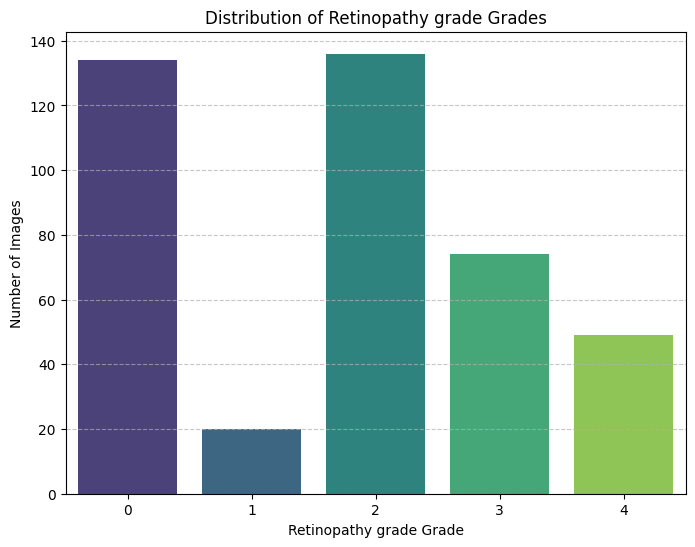

/tmp/ipython-input-2-499937576.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cleaned_name, data=df, palette='viridis')



--- Counts for each Retinopathy grade Grade ---
Retinopathy_grade
0    134
1     20
2    136
3     74
4     49
Name: count, dtype: int64

--- Percentage for each Retinopathy grade Grade ---
Retinopathy_grade
0    32.45
1     4.84
2    32.93
3    17.92
4    11.86
Name: proportion, dtype: float64

Successfully identified and renamed column: 'Risk of macular edema ' to 'Risk_of_macular_edema'

--- Unique grades for 'Risk of macular edema': [np.int64(0), np.int64(1), np.int64(2)] (3 unique grades) ---


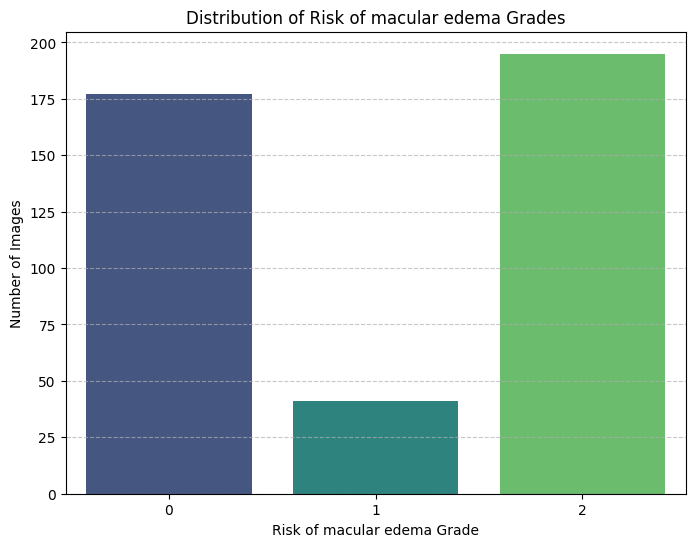


--- Counts for each Risk of macular edema Grade ---
Risk_of_macular_edema
0    177
1     41
2    195
Name: count, dtype: int64

--- Percentage for each Risk of macular edema Grade ---
Risk_of_macular_edema
0    42.86
1     9.93
2    47.22
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def analyze_grades_distribution(file_name="train.csv"):
    """
    Loads a CSV file, identifies 'Retinopathy grade' and 'Risk of macular edema' columns,
    finds unique values, visualizes their distributions, and prints counts/percentages.

    """
    try:
        df = pd.read_csv(file_name)

        print(f"--- Content of '{file_name}' (First 5 rows) ---")
        print(df.head())

        print(f"\n--- Information about '{file_name}' ---")
        df.info()


        columns_to_process = {
            'Retinopathy grade': 'Retinopathy_grade',
            'Risk of macular edema': 'Risk_of_macular_edema'
        }


        for original_name_part, cleaned_name in columns_to_process.items():
            found_col_name = None

            if original_name_part in df.columns:
                found_col_name = original_name_part
            elif original_name_part + ' ' in df.columns: # Check for trailing space
                found_col_name = original_name_part + ' '

            if found_col_name:

                df.rename(columns={found_col_name: cleaned_name}, inplace=True)
                print(f"\nSuccessfully identified and renamed column: '{found_col_name}' to '{cleaned_name}'")

                # Get unique values and number of grades
                unique_grades = sorted(df[cleaned_name].unique())
                num_grades = len(unique_grades)
                print(f"\n--- Unique grades for '{cleaned_name.replace('_', ' ')}': {unique_grades} ({num_grades} unique grades) ---")

                #   Visualize Distribution
                plt.figure(figsize=(8, 6))
                sns.countplot(x=cleaned_name, data=df, palette='viridis')
                plt.title(f'Distribution of {cleaned_name.replace("_", " ")} Grades')
                plt.xlabel(f'{cleaned_name.replace("_", " ")} Grade')
                plt.ylabel('Number of Images')
                plt.xticks(ticks=range(len(unique_grades)), labels=[str(g) for g in unique_grades])
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.show()


                print(f"\n--- Counts for each {cleaned_name.replace('_', ' ')} Grade ---")
                print(df[cleaned_name].value_counts().sort_index())

                print(f"\n--- Percentage for each {cleaned_name.replace('_', ' ')} Grade ---")
                print(df[cleaned_name].value_counts(normalize=True).mul(100).round(2).sort_index())
            else:
                print(f"\nError: '{original_name_part}' column not found in the CSV.")
                print(f"Available columns are: {df.columns.tolist()}")

    except FileNotFoundError:
        print(f"Error: The file '{file_name}' was not found.")
        print("Please ensure the CSV file is in the same directory as the script or provide the full path.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    analyze_grades_distribution("/content/drive/MyDrive/idrid/2. Groundtruths/train.csv") # Ensure "train.csv" is in the same directory

#Data Handling and Preprocessing:

In [ ]:
import pandas as pd
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

In [ ]:

BASE_DIR = '/content/drive/MyDrive/idrid/'
IMAGE_DIR_TRAIN = "/content/drive/MyDrive/idrid/1. Original Images/a. Training Set"
IMAGE_DIR_TEST = "/content/drive/MyDrive/idrid/1. Original Images/b. Testing Set"
CSV_PATH_TRAIN = "/content/drive/MyDrive/idrid/2. Groundtruths/train.csv"
CSV_PATH_TEST = "/content/drive/MyDrive/idrid/2. Groundtruths/test.csv"


In [ ]:
class IDRiDDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

        # Clean column names for easier access, handling potential trailing spaces
        if 'Image name' in self.annotations.columns:
            self.annotations.rename(columns={'Image name': 'Image_name'}, inplace=True)
        elif 'Image name ' in self.annotations.columns:
            self.annotations.rename(columns={'Image name ': 'Image_name'}, inplace=True)

        if 'Retinopathy grade' in self.annotations.columns:
            self.annotations.rename(columns={'Retinopathy grade': 'Retinopathy_grade'}, inplace=True)
        elif 'Retinopathy grade ' in self.annotations.columns: # Check for trailing space
            self.annotations.rename(columns={'Retinopathy grade ': 'Retinopathy_grade'}, inplace=True)

        if 'Risk of macular edema' in self.annotations.columns:
            self.annotations.rename(columns={'Risk of macular edema': 'Risk_of_macular_edema'}, inplace=True)
        elif 'Risk of macular edema ' in self.annotations.columns: # Check for trailing space
            self.annotations.rename(columns={'Risk of macular edema ': 'Risk_of_macular_edema'}, inplace=True)

        # Check if the required columns exist after renaming attempts
        if 'Retinopathy_grade' not in self.annotations.columns or \
           'Risk_of_macular_edema' not in self.annotations.columns or \
           'Image_name' not in self.annotations.columns:
            raise ValueError("Required columns 'Image name', 'Retinopathy grade' and 'Risk of macular edema' not found or incorrectly named in CSV.")


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name_csv = self.annotations.loc[idx, 'Image_name']
        img_path = os.path.join(self.image_dir, img_name_csv + '.jpg') # Assuming images are .jpg

        try:
            image = Image.open(img_path).convert('RGB') # Ensure 3 channels
        except FileNotFoundError:
            # print(f"Error: Image file not found at {img_path}. Skipping this image.")
            return None # Return None if image not found, to be handled by collate_fn
        except Exception as e:
            # print(f"Error loading image {img_path}: {e}. Skipping this image.")
            return None

        # Get labels
        ret_grade = self.annotations.loc[idx, 'Retinopathy_grade']
        dme_grade = self.annotations.loc[idx, 'Risk_of_macular_edema']

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Return image and labels as tensors
        return image, torch.tensor(ret_grade, dtype=torch.long), torch.tensor(dme_grade, dtype=torch.long)


In [ ]:
def collate_fn_remove_none(batch):
    # Filter out samples where __getitem__ returned None (e.g., missing image)
    batch = list(filter(lambda x: x is not None, batch)) # Filter out None tuples
    if not batch: # If all samples in batch were None
        return torch.tensor([]), torch.tensor([]), torch.tensor([]) # Return empty tensors
    return torch.utils.data.dataloader.default_collate(batch)



In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)), # Resize images to a consistent size
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.RandomRotation(15), # Randomly rotate the image by a small degree
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Randomly change brightness, contrast, etc.
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet means and stds
])

# Transformations for validation/testing (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:

print("--- Setting up Training Data ---")
train_dataset = IDRiDDataset(csv_file=CSV_PATH_TRAIN,
                              image_dir=IMAGE_DIR_TRAIN,
                              transform=train_transforms)
# Set num_workers=0 to avoid CUDA/multiprocessing issues if any
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
print(f"Number of training samples: {len(train_dataset)}")

# Get one batch to verify
for images, dr_grades, dme_grades in train_loader:
    if images is None: # Handle cases where image loading might fail
        continue
    print(f"Shape of one batch of images: {images.shape}")
    print(f"Shape of one batch of DR grades: {dr_grades.shape}")
    print(f"Shape of one batch of DME grades: {dme_grades.shape}")
    break # Just get one batch
else:
    print("Could not load any valid batches from train_loader. Check data or paths.")


print("\n--- Setting up Test Data ---")
test_dataset = IDRiDDataset(csv_file=CSV_PATH_TEST,
                            image_dir=IMAGE_DIR_TEST,
                            transform=val_test_transforms)
# Set num_workers=0 to avoid CUDA/multiprocessing issues if any
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
print(f"Number of test samples: {len(test_dataset)}")

# Get one batch to verify
for images, dr_grades, dme_grades in test_loader:
    if images is None: # Handle cases where image loading might fail
        continue
    print(f"Shape of one batch of images: {images.shape}")
    print(f"Shape of one batch of DR grades: {dr_grades.shape}")
    print(f"Shape of one batch of DME grades: {dme_grades.shape}")
    break # Just get one batch
else:
    print("Could not load any valid batches from test_loader. Check data or paths.")

print("\nData handling and preprocessing setup complete. DataLoaders are ready.")


--- Setting up Training Data ---
Number of training samples: 413
Shape of one batch of images: torch.Size([32, 3, 256, 256])
Shape of one batch of DR grades: torch.Size([32])
Shape of one batch of DME grades: torch.Size([32])

--- Setting up Test Data ---
Number of test samples: 103
Shape of one batch of images: torch.Size([32, 3, 256, 256])
Shape of one batch of DR grades: torch.Size([32])
Shape of one batch of DME grades: torch.Size([32])

Data handling and preprocessing setup complete. DataLoaders are ready.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
class MultiTaskResNet(nn.Module):
    def __init__(self, num_classes_ret, num_classes_dme):
        super(MultiTaskResNet, self).__init__()
        # Load pre-trained ResNet-50
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Freeze all parameters in the pre-trained layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer with two new heads
        num_ftrs = self.resnet.fc.in_features # Features before the final classification layer

        # Head for Retinopathy Grade classification
        self.retinopathy_head = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes_ret)
        )

        # Head for Macular Edema Risk classification
        self.dme_head = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes_dme)
        )
        self.resnet.fc = nn.Identity() # Remove the original fc layer

    def forward(self, x):
        features = self.resnet(x)
        ret_output = self.retinopathy_head(features)
        dme_output = self.dme_head(features)
        return ret_output, dme_output

# --- Initialize Model and Move to Device ---
# Number of classes based on previous data analysis (Retinopathy: 0-4=5 classes, DME: 0-2=3 classes)
num_classes_retinopathy = 5
num_classes_dme = 3


In [ ]:
model = MultiTaskResNet(num_classes_retinopathy, num_classes_dme).to(device)
print("\n--- Model Architecture (ResNet-50 with two heads) ---")
print(model)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]



--- Model Architecture (ResNet-50 with two heads) ---
MultiTaskResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): R

In [ ]:
criterion_ret = nn.CrossEntropyLoss()
criterion_dme = nn.CrossEntropyLoss()

# Optimizer: Adam is a good general-purpose optimizer
# Only optimize parameters that are unfrozen (i.e., the new heads)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\n--- Loss Functions and Optimizer Defined ---")
print(f"Retinopathy Loss Function: {criterion_ret}")
print(f"Macular Edema Loss Function: {criterion_dme}")
print(f"Optimizer: {optimizer}")
print(f"Learning Rate: {optimizer.defaults['lr']}")



--- Loss Functions and Optimizer Defined ---
Retinopathy Loss Function: CrossEntropyLoss()
Macular Edema Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning Rate: 0.001


In [ ]:
try:
    print("\n--- Setting up Training Data ---")
    train_dataset = IDRiDDataset(csv_file=CSV_PATH_TRAIN,
                                 image_dir=IMAGE_DIR_TRAIN,
                                 transform=train_transforms)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn_remove_none)
    print(f"Number of training samples: {len(train_dataset)}")

    # Get one batch to verify data shapes and model output
    for images, dr_grades, dme_grades in train_loader:
        if images.numel() == 0: # Check if the batch is empty due to filtering
            print("Skipped an empty batch (e.g., due to missing images).")
            continue
        print(f"Shape of one batch of images: {images.shape}")
        print(f"Shape of one batch of DR grades: {dr_grades.shape}")
        print(f"Shape of one batch of DME grades: {dme_grades.shape}")

        # Verify model output shapes
        images = images.to(device)
        ret_outputs, dme_outputs = model(images)
        print(f"Shape of Retinopathy grade outputs: {ret_outputs.shape}")
        print(f"Shape of Macular Edema risk outputs: {dme_outputs.shape}")

        # Verify loss calculation
        loss_ret = criterion_ret(ret_outputs, dr_grades.to(device))
        loss_dme = criterion_dme(dme_outputs, dme_grades.to(device))
        total_loss = loss_ret + loss_dme
        print(f"Sample Retinopathy Loss: {loss_ret.item():.4f}")
        print(f"Sample Macular Edema Loss: {loss_dme.item():.4f}")
        print(f"Sample Total Loss: {total_loss.item():.4f}")
        break # Just get one batch and break


    print("\n--- Setting up Test Data ---")
    test_dataset = IDRiDDataset(csv_file=CSV_PATH_TEST,
                                image_dir=IMAGE_DIR_TEST,
                                transform=val_test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn_remove_none)
    print(f"Number of test samples: {len(test_dataset)}")

    # Get one batch to verify data shapes and model output
    for images, dr_grades, dme_grades in test_loader:
        if images.numel() == 0: # Check if the batch is empty due to filtering
            print("Skipped an empty batch (e.g., due to missing images).")
            continue
        print(f"Shape of one batch of images: {images.shape}")
        print(f"Shape of one batch of DR grades: {dr_grades.shape}")
        print(f"Shape of one batch of DME grades: {dme_grades.shape}")

        # Verify model output shapes
        images = images.to(device)
        ret_outputs, dme_outputs = model(images)
        print(f"Shape of Retinopathy grade outputs: {ret_outputs.shape}")
        print(f"Shape of Macular Edema risk outputs: {dme_outputs.shape}")
        break # Just get one batch and break

    print("\nAll setup complete: DataLoaders, Model, Loss Functions, and Optimizer are ready.")

except FileNotFoundError as e:
    print(f"Error: A file or directory was not found. Please check your paths.")
    print(f"Missing: {e.filename}")
    print(f"Expected image directories: {IMAGE_DIR_TRAIN}, {IMAGE_DIR_TEST}")
    print(f"Expected CSV files: {CSV_PATH_TRAIN}, {CSV_PATH_TEST}")
except ValueError as e:
    print(f"Error in CSV processing: {e}")
except Exception as e:
    print(f"An unexpected error occurred during data loading, model setup, or loss/optimizer definition: {e}")


--- Setting up Training Data ---
Number of training samples: 413
Shape of one batch of images: torch.Size([32, 3, 256, 256])
Shape of one batch of DR grades: torch.Size([32])
Shape of one batch of DME grades: torch.Size([32])
Shape of Retinopathy grade outputs: torch.Size([32, 5])
Shape of Macular Edema risk outputs: torch.Size([32, 3])
Sample Retinopathy Loss: 1.7351
Sample Macular Edema Loss: 1.1477
Sample Total Loss: 2.8828

--- Setting up Test Data ---
Number of test samples: 103
Shape of one batch of images: torch.Size([32, 3, 256, 256])
Shape of one batch of DR grades: torch.Size([32])
Shape of one batch of DME grades: torch.Size([32])
Shape of Retinopathy grade outputs: torch.Size([32, 5])
Shape of Macular Edema risk outputs: torch.Size([32, 3])

All setup complete: DataLoaders, Model, Loss Functions, and Optimizer are ready.


Using device: cuda

--- Initializing DataLoaders ---
Train dataset size: 413 samples
Test dataset size: 103 samples


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Starting Training ---
  Epoch [1/10], Batch [10/13], Total Loss: 2.3982, DR Loss: 1.4102, DME Loss: 0.9880
Epoch 1 finished. Total Loss: 2.3200, Time: 59.79s
  Epoch [2/10], Batch [10/13], Total Loss: 2.0903, DR Loss: 1.2966, DME Loss: 0.7937
Epoch 2 finished. Total Loss: 2.0517, Time: 58.25s
  Epoch [3/10], Batch [10/13], Total Loss: 1.8663, DR Loss: 1.1772, DME Loss: 0.6891
Epoch 3 finished. Total Loss: 1.8624, Time: 60.13s
  Epoch [4/10], Batch [10/13], Total Loss: 1.7434, DR Loss: 1.1912, DME Loss: 0.5522
Epoch 4 finished. Total Loss: 1.7714, Time: 57.45s
  Epoch [5/10], Batch [10/13], Total Loss: 1.5243, DR Loss: 1.1720, DME Loss: 0.3522
Epoch 5 finished. Total Loss: 1.5799, Time: 56.02s
  Epoch [6/10], Batch [10/13], Total Loss: 1.9971, DR Loss: 1.4749, DME Loss: 0.5222
Epoch 6 finished. Total Loss: 1.6336, Time: 56.99s
  Epoch [7/10], Batch [10/13], Total Loss: 1.2410, DR Loss: 0.9636, DME Loss: 0.2774
Epoch 7 finished. Total Loss: 1.5248, Time: 57.21s
  Epoch [8/10], Batch

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



--- Starting Evaluation ---

--- Diabetic Retinopathy (DR) Classification Report ---
              precision    recall  f1-score   support

  DR Grade 0     0.7111    0.9412    0.8101        34
  DR Grade 1     0.0000    0.0000    0.0000         5
  DR Grade 2     0.3793    0.3438    0.3607        32
  DR Grade 3     0.0000    0.0000    0.0000        19
  DR Grade 4     0.2069    0.4615    0.2857        13

    accuracy                         0.4757       103
   macro avg     0.2595    0.3493    0.2913       103
weighted avg     0.3787    0.4757    0.4155       103


--- Diabetic Macular Edema (DME) Classification Report ---
              precision    recall  f1-score   support

 DME Grade 0     0.7593    0.9111    0.8283        45
 DME Grade 1     0.0000    0.0000    0.0000        10
 DME Grade 2     0.8163    0.8333    0.8247        48

    accuracy                         0.7864       103
   macro avg     0.5252    0.5815    0.5510       103
weighted avg     0.7121    0.7864    0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Visualization saved to augmented_images_visualization.png

--- Predicting on 15 Random Test Images ---
----------------------------------------------------------------------
Image Name           | GT DR   | Pred DR   | GT DME   | Pred DME  
----------------------------------------------------------------------
IDRiD_084            | 2       | 0         | 2        | 0         
IDRiD_077            | 0       | 0         | 0        | 0         
IDRiD_037            | 0       | 0         | 0        | 0         
IDRiD_066            | 3       | 4         | 2        | 2         
IDRiD_055            | 0       | 0         | 0        | 0         
IDRiD_091            | 2       | 4         | 2        | 2         
IDRiD_092            | 0       | 0         | 0        | 0         
IDRiD_046            | 2       | 0         | 1        | 0         
IDRiD_052            | 0       | 0         | 0        | 0         
IDRiD_005            | 4       | 2         | 1        | 2         
IDRiD_103         

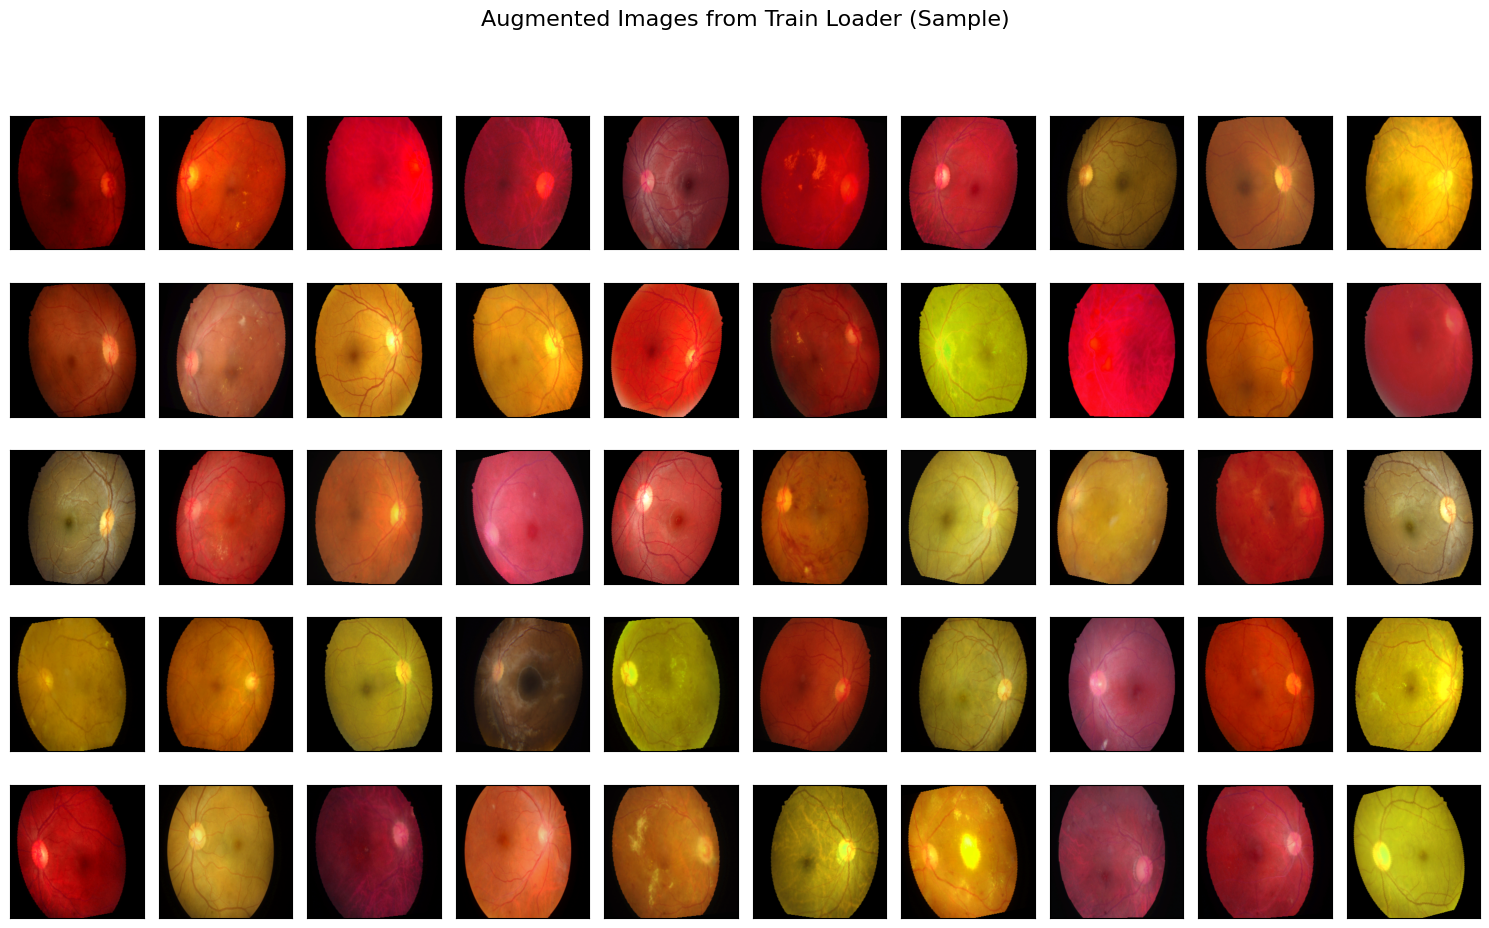

In [ ]:
import pandas as pd
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# --- 0. Configuration and File Paths ---
# IMPORTANT: Adjust BASE_DIR if your Google Drive path is different
#BASE_DIR = '/content/drive/MyDrive/idrid/'

#IMAGE_DIR_TRAIN = os.path.join(BASE_DIR, '1. Original Images/a. Training set')
#IMAGE_DIR_TEST = os.path.join(BASE_DIR, '1. Original Images/b. Testing set')

#CSV_PATH_TRAIN = os.path.join(BASE_DIR, '2. Groundtruths/train.csv')
#CSV_PATH_TEST = os.path.join(BASE_DIR, '2. Groundtruths/test.csv')

MODEL_SAVE_PATH = os.path.join(BASE_DIR, 'multi_task_resnet.pth')


BASE_DIR = '/content/drive/MyDrive/idrid/'
IMAGE_DIR_TRAIN = "/content/drive/MyDrive/idrid/1. Original Images/a. Training Set"
IMAGE_DIR_TEST = "/content/drive/MyDrive/idrid/1. Original Images/b. Testing Set"
CSV_PATH_TRAIN = "/content/drive/MyDrive/idrid/2. Groundtruths/train.csv"
CSV_PATH_TEST = "/content/drive/MyDrive/idrid/2. Groundtruths/test.csv"

NUM_DR_CLASSES = 5 # 0 to 4
NUM_DME_CLASSES = 3 # 0 to 2
BATCH_SIZE = 32
NUM_EPOCHS = 10 # Set to a lower number for quicker testing, e.g., 5-10
LEARNING_RATE = 0.001

# --- 1. Custom PyTorch Dataset ---
class IDRiDDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

        # Rename columns to standardized names for easier access
        col_mapping = {
            'Image name': 'Image_name',
            'Image name ': 'Image_name', # Handle trailing space
            'Retinopathy grade': 'Retinopathy_grade',
            'Retinopathy grade ': 'Retinopathy_grade', # Handle trailing space
            'Risk of macular edema': 'Risk_of_macular_edema',
            'Risk of macular edema ': 'Risk_of_macular_edema' # Handle trailing space
        }
        self.annotations.rename(columns=col_mapping, inplace=True)

        # Validate required columns
        required_cols = ['Image_name', 'Retinopathy_grade', 'Risk_of_macular_edema']
        if not all(col in self.annotations.columns for col in required_cols):
            missing_cols = [col for col in required_cols if col not in self.annotations.columns]
            raise ValueError(f"Missing required columns in CSV: {missing_cols}. "
                             f"Available columns: {self.annotations.columns.tolist()}")

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name_csv = self.annotations.loc[idx, 'Image_name']
        img_path = os.path.join(self.image_dir, img_name_csv + '.jpg')

        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, IOError) as e:
            # print(f"Warning: Could not load image {img_path}: {e}. Returning None.")
            return None # Return None if image file is not found or corrupted

        ret_grade = self.annotations.loc[idx, 'Retinopathy_grade']
        dme_grade = self.annotations.loc[idx, 'Risk_of_macular_edema']

        if self.transform:
            image = self.transform(image)

        # Return image, DR grade, DME grade, and image name
        return image, torch.tensor(ret_grade, dtype=torch.long), \
               torch.tensor(dme_grade, dtype=torch.long), img_name_csv

# --- Custom Collate Function for DataLoaders to handle None values ---
# This is crucial when __getitem__ might return None for missing/corrupted images
def collate_fn_remove_none_and_unpack(batch):
    batch = list(filter(lambda x: x is not None, batch)) # Filter out None samples
    if not batch: # Return empty tensors if the entire batch became empty
        return torch.tensor([]), torch.tensor([]), torch.tensor([]), []

    # Unpack and stack the remaining valid samples
    images = torch.stack([item[0] for item in batch])
    dr_grades = torch.stack([item[1] for item in batch])
    dme_grades = torch.stack([item[2] for item in batch])
    img_names = [item[3] for item in batch] # Image names are kept as a list

    return images, dr_grades, dme_grades, img_names

# --- 2. Image Transformations ---
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. Denormalization Function for Visualization ---
# ImageNet statistics for inverse normalization
INV_NORM_MEAN = torch.tensor([0.485, 0.456, 0.406])
INV_NORM_STD = torch.tensor([0.229, 0.224, 0.225])

def inverse_normalize(tensor_image):
    return tensor_image * INV_NORM_STD.view(3, 1, 1) + INV_NORM_MEAN.view(3, 1, 1)

# --- 4. Multi-Task ResNet Model Definition ---
class MultiTaskResNet(nn.Module):
    def __init__(self, num_dr_classes, num_dme_classes, pretrained=True):
        super(MultiTaskResNet, self).__init__()
        resnet = models.resnet50(pretrained=pretrained)
        # Remove original average pooling and fully connected layer
        self.features = nn.Sequential(*list(resnet.children())[:-2])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Global average pooling
        # Two separate fully connected layers for each task
        self.fc_dr = nn.Linear(resnet.fc.in_features, num_dr_classes)
        self.fc_dme = nn.Linear(resnet.fc.in_features, num_dme_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1) # Flatten for FC layers
        dr_output = self.fc_dr(x)
        dme_output = self.fc_dme(x)
        return dr_output, dme_output

# --- 5. Training Function ---
def train_model(model, train_loader, optimizer, criterion_dr, criterion_dme, num_epochs, device):
    model.train() # Set model to training mode
    print("\n--- Starting Training ---")
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        running_total_loss = 0.0
        running_dr_loss = 0.0
        running_dme_loss = 0.0

        for batch_idx, (images, dr_grades, dme_grades, _) in enumerate(train_loader):
            # Skip empty batches if collate_fn removed all samples
            if images.numel() == 0:
                continue

            images = images.to(device)
            dr_grades = dr_grades.to(device)
            dme_grades = dme_grades.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            dr_outputs, dme_outputs = model(images)

            # Calculate loss for each task
            loss_dr = criterion_dr(dr_outputs, dr_grades)
            loss_dme = criterion_dme(dme_outputs, dme_grades)
            total_loss = loss_dr + loss_dme # Combine losses for multi-task learning

            # Backward pass and optimize
            total_loss.backward()
            optimizer.step()

            running_total_loss += total_loss.item()
            running_dr_loss += loss_dr.item()
            running_dme_loss += loss_dme.item()

            if (batch_idx + 1) % 10 == 0: # Print every 10 batches
                print(f"  Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], "
                      f"Total Loss: {total_loss.item():.4f}, DR Loss: {loss_dr.item():.4f}, DME Loss: {loss_dme.item():.4f}")

        epoch_time = time.time() - start_time
        avg_total_loss = running_total_loss / len(train_loader)
        print(f"Epoch {epoch + 1} finished. Total Loss: {avg_total_loss:.4f}, Time: {epoch_time:.2f}s")

    print("--- Training Complete ---")
    # Save the trained model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")

# --- 6. Evaluation Function ---
def evaluate_model(model, test_loader, device, num_dr_classes, num_dme_classes):
    model.eval() # Set model to evaluation mode
    print("\n--- Starting Evaluation ---")
    all_dr_preds = []
    all_dr_labels = []
    all_dme_preds = []
    all_dme_labels = []

    with torch.no_grad(): # Disable gradient calculations during evaluation
        for images, dr_grades, dme_grades, _ in test_loader:
            if images.numel() == 0: # Skip empty batches
                continue

            images = images.to(device)
            dr_grades = dr_grades.to(device)
            dme_grades = dme_grades.to(device)

            dr_outputs, dme_outputs = model(images)

            # Get predicted classes (index of the max log-probability)
            _, dr_predicted = torch.max(dr_outputs.data, 1)
            _, dme_predicted = torch.max(dme_outputs.data, 1)

            all_dr_preds.extend(dr_predicted.cpu().numpy())
            all_dr_labels.extend(dr_grades.cpu().numpy())
            all_dme_preds.extend(dme_predicted.cpu().numpy())
            all_dme_labels.extend(dme_grades.cpu().numpy())

    print("\n--- Diabetic Retinopathy (DR) Classification Report ---")
    print(classification_report(all_dr_labels, all_dr_preds,
                                target_names=[f'DR Grade {i}' for i in range(num_dr_classes)],
                                digits=4))

    print("\n--- Diabetic Macular Edema (DME) Classification Report ---")
    print(classification_report(all_dme_labels, all_dme_preds,
                                target_names=[f'DME Grade {i}' for i in range(num_dme_classes)],
                                digits=4))
    print("--- Evaluation Complete ---")

# --- 7. Visualization Function for Train Loader (Augmented Images) ---
def visualize_augmented_images(train_loader, num_images=50):
    print("\n--- Visualizing Augmented Images from Train Loader ---")
    fig = plt.figure(figsize=(15, 10))
    images_shown = 0

    # Get a few batches until we have enough images or run out of data
    for i, (images, _, _, _) in enumerate(train_loader):
        if images.numel() == 0: # Skip empty batches
            continue

        for j in range(images.shape[0]):
            if images_shown >= num_images:
                break # Stop if we have enough images

            ax = fig.add_subplot(5, 10, images_shown + 1, xticks=[], yticks=[])

            # Get the image, move to CPU, denormalize, and convert to NumPy
            img = images[j].cpu()
            img = inverse_normalize(img)
            np_img = img.permute(1, 2, 0).numpy() # Convert from C, H, W to H, W, C

            # Clip values to [0, 1] for proper display in case of minor overshoots
            np_img = np.clip(np_img, 0, 1)

            ax.imshow(np_img)
            images_shown += 1
        if images_shown >= num_images:
            break

    plt.suptitle("Augmented Images from Train Loader (Sample)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.savefig('augmented_images_visualization.png')
    print(f"Visualization saved to augmented_images_visualization.png")
    # plt.show() # Uncomment if running in an interactive environment like Colab directly

# --- 8. Prediction Function for Random Test Images ---
def predict_random_test_images(model, test_dataset, num_samples=15, device='cpu'):
    model.eval() # Set model to evaluation mode
    print(f"\n--- Predicting on {num_samples} Random Test Images ---")

    # Filter out invalid indices (missing/corrupted images) before sampling
    valid_indices = []
    for i in range(len(test_dataset)):
        # Attempt to get the sample to check for None without full processing
        # This will call __getitem__ and return None if the image is problematic
        temp_sample = test_dataset[i]
        if temp_sample is not None:
            valid_indices.append(i)

    if not valid_indices:
        print("Error: No valid images found in the test dataset to sample from. Check image files and paths.")
        return

    # Ensure we don't try to pick more samples than available valid ones
    actual_num_samples = min(num_samples, len(valid_indices))
    random_indices = random.sample(valid_indices, actual_num_samples)

    print("-" * 70)
    print(f"{'Image Name':<20} | {'GT DR':<7} | {'Pred DR':<9} | {'GT DME':<8} | {'Pred DME':<10}")
    print("-" * 70)

    with torch.no_grad():
        for idx in random_indices:
            sample_data = test_dataset[idx] # This will be a valid sample based on pre-filtering

            image, gt_dr, gt_dme, img_name = sample_data

            # Add a batch dimension (1, C, H, W) and move to device
            image = image.unsqueeze(0).to(device)

            dr_output, dme_output = model(image)

            # Get predicted class (index with max log-probability)
            _, pred_dr = torch.max(dr_output, 1)
            _, pred_dme = torch.max(dme_output, 1)

            print(f"{img_name:<20} | {gt_dr.item():<7} | {pred_dr.item():<9} | {gt_dme.item():<8} | {pred_dme.item():<10}")
    print("-" * 70)
    print("--- Prediction Complete ---")

# --- Main Execution Block ---
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    try:
        # 1. Initialize Datasets and DataLoaders
        print("\n--- Initializing DataLoaders ---")
        train_dataset = IDRiDDataset(csv_file=CSV_PATH_TRAIN,
                                     image_dir=IMAGE_DIR_TRAIN,
                                     transform=train_transforms)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=0, collate_fn=collate_fn_remove_none_and_unpack)

        test_dataset = IDRiDDataset(csv_file=CSV_PATH_TEST,
                                    image_dir=IMAGE_DIR_TEST,
                                    transform=val_test_transforms)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                 num_workers=0, collate_fn=collate_fn_remove_none_and_unpack)

        print(f"Train dataset size: {len(train_dataset)} samples")
        print(f"Test dataset size: {len(test_dataset)} samples")

        # 2. Initialize Model, Loss Functions, and Optimizer
        model = MultiTaskResNet(num_dr_classes=NUM_DR_CLASSES, num_dme_classes=NUM_DME_CLASSES, pretrained=True)
        model.to(device)

        criterion_dr = nn.CrossEntropyLoss()
        criterion_dme = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # 3. Train the Model
        train_model(model, train_loader, optimizer, criterion_dr, criterion_dme, NUM_EPOCHS, device)

        # 4. Evaluate the Model (Loads the saved model to ensure we evaluate the final state)
        print("\n--- Starting Final Evaluation on Test Set ---")
        loaded_model = MultiTaskResNet(num_dr_classes=NUM_DR_CLASSES, num_dme_classes=NUM_DME_CLASSES, pretrained=False)
        loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        loaded_model.to(device)
        evaluate_model(loaded_model, test_loader, device, NUM_DR_CLASSES, NUM_DME_CLASSES)

        # 5. Visualize Augmented Images from Train Loader
        # Create a new loader for visualization to avoid disrupting the main training loader
        # This will show you what the augmented images actually look like
        visualize_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                      num_workers=0, collate_fn=collate_fn_remove_none_and_unpack)
        visualize_augmented_images(visualize_loader)

        # 6. Predict on Random Test Images
        # Use the loaded_model which has the final trained weights
        predict_random_test_images(loaded_model, test_dataset, num_samples=15, device=device)

    except FileNotFoundError as e:
        print(f"Error: A required file or directory was not found. Please check your paths.")
        print(f"Missing: {e.filename}. Ensure data directories and CSVs exist and are accessible at: {BASE_DIR}")
    except ValueError as e:
        print(f"Configuration Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")